In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


heisenberg_valid_file = 'data/heisenberg_xyz_valid.h5'
ti_valid_file = 'data/ti_valid.h5'
fh_valid_file = 'data/fh_valid.h5'

molecule_valid_file = 'data/h2_valid.h5'

vqe_valid_file = 'data/random_vqe_valid.h5'

def get_natural_bounds(losses):

    total_losses  = np.sum(losses, axis =1)

    best_idx = np.argmin(total_losses)
    worst_idx = np.argmax(total_losses)
    return losses[best_idx], losses[worst_idx]


def get_top_k_bounds(losses, k=5):
    """Finds the mean of the top-k best and worst training histories."""
    total_losses = np.sum(losses, axis=1)  # Sum over all iterations
    best_k_indices = np.argsort(total_losses)[:k]   # Top-K best trials
    worst_k_indices = np.argsort(total_losses)[-k:] # Top-K worst trials
    lower_bound = np.mean(losses[best_k_indices], axis=0)
    upper_bound = np.mean(losses[worst_k_indices], axis=0)
    return lower_bound, upper_bound



def get_losses(valid_file, n_steps = 600):

    random_losses = []
    diff_losses = []
    dgnn_losses = []
    gin_losses = []

    with h5py.File(valid_file, 'r') as f:
        random_loss_history_group = f['loss_history']
        diff_loss_history_group = f['diff_loss_history']
        dgnn_loss_history_group = f['dgnn_loss_history']
        gin_loss_history_group = f['gin_loss_history']
        for key in random_loss_history_group.keys():
            random_loss_history = random_loss_history_group[key][...]
            diff_loss_history = diff_loss_history_group[key][...]
            dgnn_loss_history = dgnn_loss_history_group[key][...]
            gin_loss_history = gin_loss_history_group[key][...]
            random_losses.append(random_loss_history[:n_steps])
            diff_losses.append(diff_loss_history[:n_steps])
            dgnn_losses.append(dgnn_loss_history[:n_steps])
            gin_losses.append(gin_loss_history[:n_steps])

    return random_losses, diff_losses, dgnn_losses, gin_losses


def get_qasm_vqe_losses(valid_file, n_steps = 500):
    random_losses = []
    diff_losses = []
    dgnn_losses = []
    gin_losses = []

    with h5py.File(valid_file, 'r') as f:
        random_loss_history_group = f['loss_history']
        diff_loss_history_group = f['diff_loss_history']
        dgnn_loss_history_group = f['dgnn_loss_history']
        gin_loss_history_group = f['gin_loss_history']
        for key in random_loss_history_group.keys():
            random_loss_history = random_loss_history_group[key][...]
            diff_loss_history = diff_loss_history_group[key][...]
            dgnn_loss_history = dgnn_loss_history_group[key][...]
            gin_loss_history = gin_loss_history_group[key][...]
            random_losses.append(random_loss_history[:, 1][:n_steps])
            diff_losses.append(diff_loss_history[:, 1][:n_steps])
            dgnn_losses.append(dgnn_loss_history[:, 1][:n_steps])
            gin_losses.append(gin_loss_history[:, 1][:n_steps])
    return random_losses, diff_losses, dgnn_losses, gin_losses



plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "text.usetex": False,  # Turn this OFF to prevent LaTeX errors
    "font.family": "serif",
    "pgf.rcfonts": False,

    "axes.labelsize": 14,  # Increase label font size
    "axes.titlesize": 16,  # Increase title font size
    "legend.fontsize": 12,  # Increase legend font size
    "xtick.labelsize": 15,  # Increase x-axis tick size
    "ytick.labelsize": 15,  # Increase y-axis tick size
    "lines.linewidth": 2.5,  # Make lines thicker
    "lines.markersize": 8,  # Increase marker size
    "grid.alpha": 0.3,  # Make grid less prominent
    "figure.figsize": (6, 3.4),  # Set consistent figure size
})
def plot_curves(file, criterion='percentile',  percent_range = [25, 75], n_steps = 600, y_scale = 'natural', model_name = 'Heisenberg XYZ Model'):
    
    if 'QASMBench' in model_name:
        random_losses, diff_losses, dgnn_losses, gin_losses = get_qasm_vqe_losses(file, n_steps)
    else:
        random_losses, diff_losses, dgnn_losses, gin_losses = get_losses(file, n_steps)
   
    if y_scale == 'natural':
        random_losses = np.array(random_losses)
        diff_losses = np.array(diff_losses)
        dgnn_losses = np.array(dgnn_losses)
        gin_losses = np.array(gin_losses)

      

    elif y_scale == 'log':
        ground_loss = np.min([random_losses, diff_losses, dgnn_losses, gin_losses])
        random_losses = np.log(np.array(random_losses) - ground_loss + 1e-10)
        diff_losses = np.log(np.array(diff_losses) - ground_loss + 1e-10)
        dgnn_losses = np.log(np.array(dgnn_losses) - ground_loss + 1e-10)
        gin_losses = np.log(np.array(gin_losses) - ground_loss + 1e-10)


    random_mean = np.mean(random_losses, axis=0)
    diff_mean = np.mean(diff_losses, axis=0)
    dgnn_mean = np.mean(dgnn_losses, axis=0)
    gin_mean = np.mean(gin_losses, axis=0)
    random_std = np.std(random_losses, axis=0)
    diff_std = np.std(diff_losses, axis=0)
    dgnn_std = np.std(dgnn_losses, axis=0)
    gin_std = np.std(gin_losses, axis=0)

    if criterion == 'percentile':
        random_lower, random_upper = np.percentile(random_losses, percent_range, axis=0)
        diff_lower, diff_upper = np.percentile(diff_losses, percent_range, axis=0)
        dgnn_lower, dgnn_upper = np.percentile(dgnn_losses, percent_range, axis=0)
        gin_lower, gin_upper = np.percentile(gin_losses, percent_range, axis=0)

    elif criterion == 'std':
        random_lower = random_mean - random_std
        random_upper = random_mean + random_std
        diff_lower = diff_mean - diff_std
        diff_upper = diff_mean + diff_std
        dgnn_lower = dgnn_mean - dgnn_std
        dgnn_upper = dgnn_mean + dgnn_std
        gin_lower = gin_mean - gin_std
        gin_upper = gin_mean + gin_std

    elif criterion == 'natural':
        random_lower, random_upper = get_natural_bounds(random_losses)
        diff_lower, diff_upper = get_natural_bounds(diff_losses)
        dgnn_lower, dgnn_upper = get_natural_bounds(dgnn_losses)
        gin_lower, gin_upper = get_natural_bounds(gin_losses)






    iterations = np.arange(n_steps)
    plt.figure()

    # plt.plot(iterations, random_mean, 'k-.', label='Random')
    # plt.fill_between(iterations, random_lower, random_upper, color='gold', alpha=0.2, hatch='--')

    plt.plot(iterations, diff_mean, 'g:', label='Diffusion')
    plt.fill_between(iterations, diff_lower, diff_upper, color='limegreen', alpha=0.3, hatch='..')


    plt.plot(iterations, dgnn_mean, 'r--', label = 'Qracle')
    plt.fill_between(iterations, dgnn_lower, dgnn_upper, color='lightcoral', alpha=0.4)



    # plt.plot(iterations, gin_mean, 'b-', label='GIN')
    # plt.fill_between(iterations, gin_lower, gin_upper, color='royalblue', alpha=0.3)
    plt.xlabel('Iterations')
    
    plt.ylabel(r'$\log |E_{\mathrm{gs}} - \mathrm{Loss}|$' if y_scale == 'log' else 'Loss')
  



    # plt.title(f'{model_name} Optimization Loss History')
    plt.legend(loc='upper right', frameon=True)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()

    # Save Figure in High-Quality
    plt.savefig(f"{model_name.replace(' ', '_')}.pdf", dpi=300, bbox_inches='tight', format="pdf")
    plt.show()







# plt.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     "text.usetex": False,  # Turn this OFF to prevent LaTeX errors
#     "font.family": "serif",
#     "pgf.rcfonts": False,

#     "axes.labelsize": 14,  # Increase label font size
#     "axes.titlesize": 16,  # Increase title font size
#     "legend.fontsize": 12,  # Increase legend font size
#     "xtick.labelsize": 12,  # Increase x-axis tick size
#     "ytick.labelsize": 12,  # Increase y-axis tick size
#     "lines.linewidth": 2.5,  # Make lines thicker
#     "lines.markersize": 8,  # Increase marker size
#     "grid.alpha": 0.3,  # Make grid less prominent
#     "figure.figsize": (8, 5),  # Set consistent figure size
# })


def get_init_losses(valid_file):
    """Reads the initial losses from the validation file."""
    random_init, diff_init, dgnn_init, gin_init = [], [], [], []

    # Read Data
    with h5py.File(valid_file, 'r') as f:
        for key in f['loss_history'].keys():
            random_init.append(f['loss_history'][key][0])
            diff_init.append(f['diff_loss_history'][key][0])
            dgnn_init.append(f['dgnn_loss_history'][key][0])
            gin_init.append(f['gin_loss_history'][key][0])

    return random_init, diff_init, dgnn_init, gin_init



def get_qasm_vqe_init_losses(valid_file):

    """Reads the initial losses from the QASM VQE validation file."""
    random_init, diff_init, dgnn_init, gin_init = [], [], [], []

    # Read Data
    with h5py.File(valid_file, 'r') as f:
        for key in f['loss_history'].keys():
            random_init.append(f['loss_history'][key][0, 1])
            diff_init.append(f['diff_loss_history'][key][0, 1])
            dgnn_init.append(f['dgnn_loss_history'][key][0, 1])
            gin_init.append(f['gin_loss_history'][key][0, 1])

    return random_init, diff_init, dgnn_init, gin_init


def plot_whisker_box(valid_file, whisker_range=[0, 100], model_name='Heisenberg XYZ 4 Qubit'):
    """Creates a whisker box plot with consistent styling."""
    
    if 'QASMBench' in model_name:
        random_init, diff_init, dgnn_init, gin_init = get_qasm_vqe_init_losses(valid_file)
    else:
        random_init, diff_init, dgnn_init, gin_init = get_init_losses(valid_file)




    # Convert to NumPy arrays
    random_init, diff_init, dgnn_init, gin_init = map(np.array, [random_init, diff_init, dgnn_init, gin_init])

    # Order of models (to match curve plot colors)
    model_data = [diff_init, dgnn_init, random_init]
    labels = ['Diffusion', 'Qracle', 'Random']

    # Colors to match the curve plots
    box_colors = ['limegreen', 'lightcoral', 'gold']
    
    plt.figure()

    # Create box plot
    box = plt.boxplot(model_data, positions=np.arange(len(model_data)), labels=labels, whis=whisker_range, 
                      patch_artist=True, notch=True, flierprops=dict(marker='o', markersize=6, markerfacecolor='black'))

    # Apply colors to the boxes
    for patch, color in zip(box['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.4)  # Transparency to match curve plots

    # Grid styling
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Labels and title
    plt.xlabel('Schemes')
    plt.ylabel('Initial Loss')
    # plt.title(f'{model_name} Initial Loss Distribution')

    # Save figure in high resolution (PDF for publication, PGF for LaTeX)
    plt.savefig(f"{model_name.replace(' ', '_')}_whisker.pdf", dpi=300, bbox_inches='tight', format="pdf")
    # plt.savefig(f"{model_name.replace(' ', '_')}_whisker.pgf", dpi=300, bbox_inches='tight', format="pgf")

    # Show the plot
    plt.show()



def convert_to_csvs(file_path, n_steps = 600, model_name = 'heisenberg'):

    random_losses, diff_losses, dgnn_losses, gin_losses = get_losses(file_path, n_steps)
    random_losses = np.array(random_losses)
    diff_losses = np.array(diff_losses)
    dgnn_losses = np.array(dgnn_losses)
    gin_losses = np.array(gin_losses)

    iterations = np.arange(n_steps)

    df = pd.DataFrame({
    "Iterations": iterations,
    "Random Mean": np.mean(random_losses, axis=0),
    "Diffusion Mean": np.mean(diff_losses, axis=0),
    "Qracle Mean": np.mean(dgnn_losses, axis=0),
    "GIN Mean": np.mean(gin_losses, axis=0),
    "Random Lower": np.percentile(random_losses, 25, axis=0),
    "Random Upper": np.percentile(random_losses, 75, axis=0),
    "Diffusion Lower": np.percentile(diff_losses, 25, axis=0),
    "Diffusion Upper": np.percentile(diff_losses, 75, axis=0),
    "Qracle Lower": np.percentile(dgnn_losses, 25, axis=0),
    "Qracle Upper": np.percentile(dgnn_losses, 75, axis=0),
    "GIN Lower": np.percentile(gin_losses, 25, axis=0),
    "GIN Upper": np.percentile(gin_losses, 75, axis=0),
    })

# Save the data to CSV
    df.to_csv(f"{model_name}_losses.csv", index=False)

def plot_results(file_path, n_steps = 600,  percent_range = [25, 75], whisker_range = [0, 100], model_name = 'heisenberg'):

    _, diff_losses, q_losses, _ = get_losses(file_path, n_steps)
    diff_losses = np.array(diff_losses)
    q_losses = np.array(q_losses)

    diff_mean = np.mean(diff_losses, axis=0)
    q_mean = np.mean(q_losses, axis=0)

    diff_lower, diff_upper = np.percentile(diff_losses, percent_range, axis=0)
    q_lower, q_upper = np.percentile(q_losses, percent_range, axis=0)

    random_init, diff_init, q_init, _ = get_init_losses(file_path)
    random_init = np.array(random_init)
    diff_init = np.array(diff_init)
    q_init = np.array(q_init)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6.7), gridspec_kw={'wspace': 0.3})
    
    iterations = np.arange(n_steps)
    ax1 = axes[0]
    ax1.plot(iterations, diff_mean, 'g:', label='Diffusion')
    ax1.fill_between(iterations, diff_lower, diff_upper, color='limegreen', alpha=0.3, hatch='..')

    ax1.plot(iterations, q_mean, 'r--', label='Qracle')
    ax1.fill_between(iterations, q_lower, q_upper, color='lightcoral', alpha=0.4)

    ax1.set_xlabel('Iterations', fontsize=14)
    ax1.set_ylabel('Loss', fontsize=14)

    ax1.tick_params(axis='both', labelsize=12, width=2)  # Bigger and clearer ticks
    ax1.grid(True, linestyle="--", alpha=0.3)
    ax1.legend(loc='upper right', frameon=True, fontsize=12)


    ax2 = axes[1]
    box_data = [diff_init, q_init, random_init]
    labels = ['Diffusion', 'DGNN', 'Random']
    colors = ['limegreen', 'lightcoral', 'gold']

    box = ax2.boxplot(box_data, positions=np.arange(len(box_data)), tick_labels=labels, whis=whisker_range , notch=True, patch_artist=True)

    # Apply colors
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.5)

    ax2.set_xlabel('Schemes', fontsize=14)
    ax2.set_ylabel('Initial Loss', fontsize=14)
    # ax2.set_title('Heisenberg XYZ 4-Qubit Initial Loss Distribution', fontsize=14)
    ax2.tick_params(axis='both', labelsize=12, width=2)  # Bigger and clearer ticks
    ax2.grid(axis='y', linestyle='--', alpha=0.3)

    # ----- Save the Figure -----
    plt.tight_layout(pad=0.5)  # Reduce blank space
    plt.savefig(f"{model_name}_loss_history_whisker.png", dpi=300, bbox_inches='tight', format="png")
    plt.savefig(f"{model_name}_loss_history_whisker.pdf", dpi=300, bbox_inches='tight', format="pdf")



    

In [4]:
def get_conv_steps(loss_hist, energy):

    for i in range(len(loss_hist)):
        if loss_hist[i] < energy:
            return i
    return len(loss_hist)

In [17]:
data_files = [heisenberg_valid_file, ti_valid_file, fh_valid_file, molecule_valid_file]
model_names = ['heisenberg', 'ti', 'fh', 'h2']

for file, model_name in zip(data_files, model_names):
    _, diff_losses, q_losses, _ = get_losses(file)
    diff_mean  = np.mean(diff_losses, axis=0)
    q_mean = np.mean(q_losses, axis=0)
    diff_energy = diff_mean[199]

    q_conv_step = get_conv_steps(q_mean, diff_energy)

    if model_name == 'h2':
        print(f'Diffusion initial energy for {model_name} is {diff_mean[0]}')
        print(f'Qracle initial energy for {model_name} is {q_mean[0]}')




_, diff_init, q_init, _= get_qasm_vqe_init_losses(vqe_valid_file)


diff_init = np.mean(diff_init, axis=0)
q_init = np.mean(q_init, axis=0)

print(f'Diffusion initial energy for QASMBench is {diff_init}')
print(f'Qracle initial energy for QASMBench is {q_init}')

Diffusion initial energy for h2 is -0.35911183059215546
Qracle initial energy for h2 is -0.5766929497321447
Diffusion initial energy for QASMBench is 0.021433866453245194
Qracle initial energy for QASMBench is -0.0798070180660621


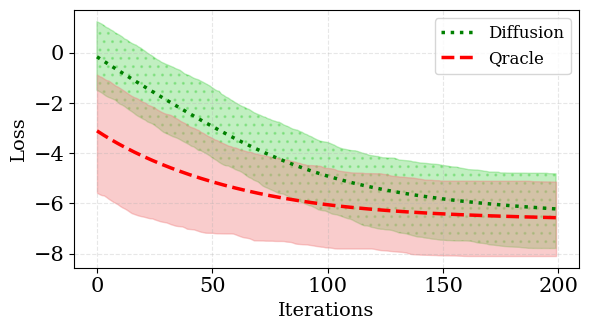

In [15]:
plot_curves(heisenberg_valid_file, criterion='percentile', percent_range=[25, 75], n_steps=200, y_scale='natural', model_name='Heisenberg XYZ Model')


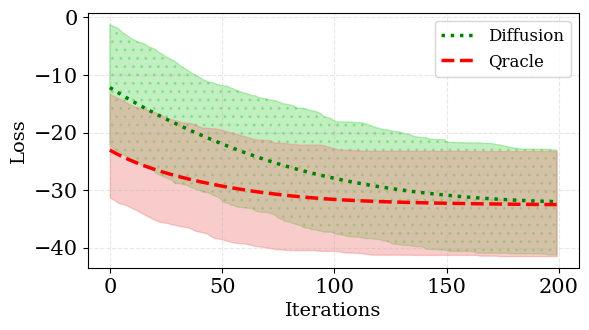

In [16]:
plot_curves(ti_valid_file, criterion='percentile', percent_range=[25, 75], n_steps=200, y_scale='natural', model_name='Transverse Ising Model')



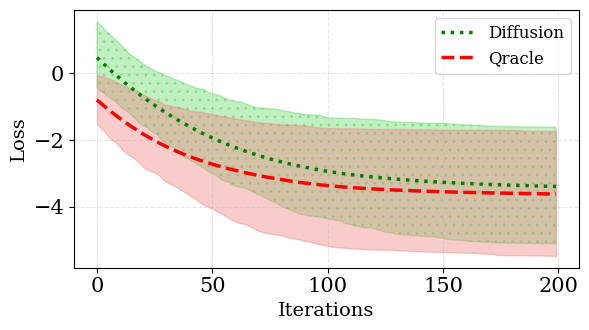

In [17]:

plot_curves(fh_valid_file, criterion='percentile', percent_range=[25, 75], y_scale= 'natural', n_steps=200, model_name='Fermi-Hubbard Model')

/tmp/ipykernel_32486/539958716.py:269: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(model_data, positions=np.arange(len(model_data)), labels=labels, whis=whisker_range,


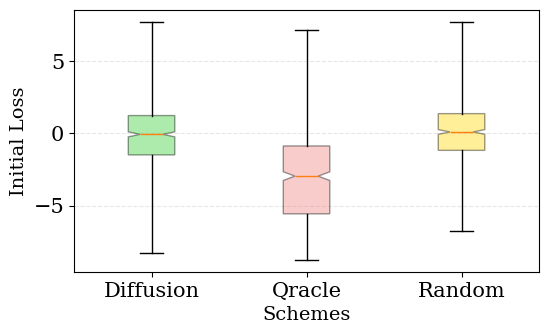

In [18]:
plot_whisker_box(heisenberg_valid_file, whisker_range=[0, 100], model_name='Heisenberg XYZ 4-Qubit')

/tmp/ipykernel_32486/539958716.py:269: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(model_data, positions=np.arange(len(model_data)), labels=labels, whis=whisker_range,


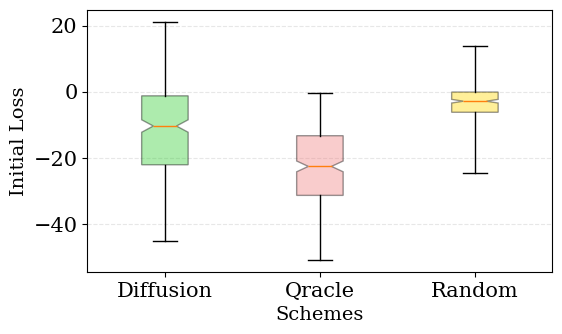

In [19]:
plot_whisker_box(ti_valid_file, whisker_range=[0, 100], model_name='Transverse Ising 8-Qubit')

/tmp/ipykernel_32486/539958716.py:269: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(model_data, positions=np.arange(len(model_data)), labels=labels, whis=whisker_range,


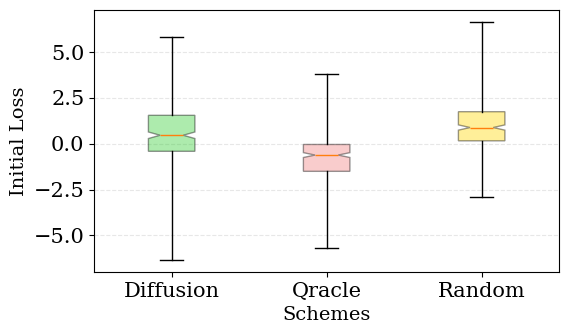

In [20]:
plot_whisker_box(fh_valid_file, whisker_range=[0, 100], model_name='Fermi-Hubbard 8-Qubit')

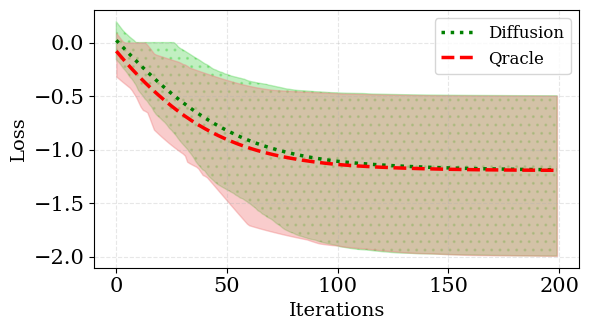

In [ ]:


plot_curves(file=vqe_valid_file, criterion='percentile', percent_range=[25, 75], n_steps=200, y_scale = 'natural', model_name='QASMBench VQE 4-Qubit')

/tmp/ipykernel_32486/539958716.py:269: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(model_data, positions=np.arange(len(model_data)), labels=labels, whis=whisker_range,


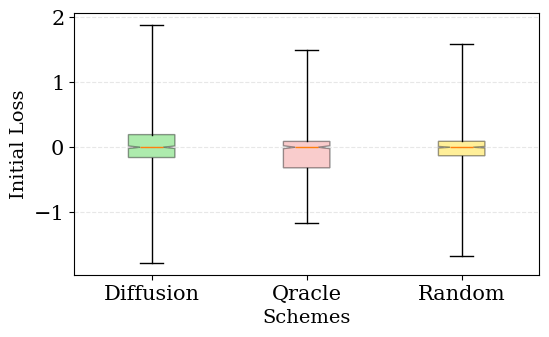

In [22]:
plot_whisker_box(valid_file=vqe_valid_file, whisker_range=[0, 100], model_name='QASMBench VQE 4-Qubit')

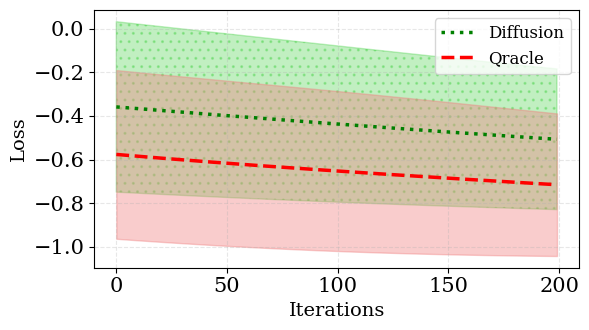

In [23]:
plot_curves(molecule_valid_file, criterion='std', percent_range=[25, 75], n_steps=200, y_scale='natural', model_name='H2 Molecule')

/tmp/ipykernel_32486/539958716.py:269: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(model_data, positions=np.arange(len(model_data)), labels=labels, whis=whisker_range,


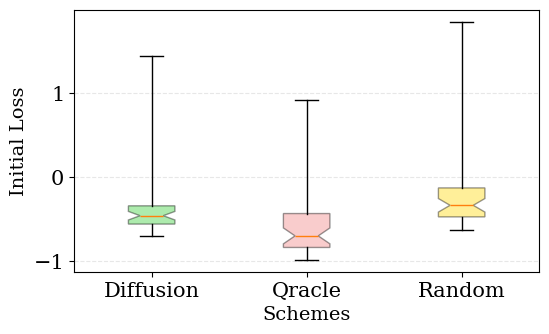

In [24]:
plot_whisker_box(molecule_valid_file, whisker_range=[0, 100], model_name='H2 Molecule')